# **ABOUT DATASET**

iFood is the lead food delivery app in Brazil, present in over a thousand cities. Keeping a high customer engagement is key for growing and consolidating the company’s position as the market leader. Data Analysts working within the data team are constantly challenged to provide insights and value to the company through open scope projects. This case intends to simulate that. In this case, you are presented a sample dataset, that mocks metainformation on the customer and on iFood campaign interactions with that customer. It is your challenge to understand the data, find business opportunities & insights and to propose any data driven action to optimize the campaigns results & generate value to the company. This case aims to evaluate your Data skills and knowledge for two possible roles:

1. Data Analyst Business:

    - Perform robust exploratory analysis, rich with business insights & data driven proposals to add value to the company and have strong communication skills to influence the decision making.
    
2. Data Advanced Analytics:

    - Perform robust exploratory analysis, using advanced analytics tools and statistical methods to generate data products to optimize business results (predictive & clusterization models, for example)
    
Key Objectives are:

1. Explore the data – don’t just plot means and counts. Provide insights, define cause and effect. Provide a better understanding of the characteristic features of respondents;

2. Propose and describe a customer segmentation based on customers behaviors;

3. Create a predictive model which allows the company to maximize the profit of the next marketing campaign.

## Importing and Inspecting Dataset

There are 24 out of 2240 missing entries for the yearly household income variable and for these values to stand out during future analysis, they will be filled with -1.

In [1]:
import pandas as pd

date_cols = ['Year_Birth', 'Dt_Customer']
marketing = pd.read_csv('marketing_campaign.csv', 
                        delimiter=';', 
                        parse_dates=date_cols).fillna(-1)

After calculating age of the customers, it is evident that there are three individuals aged 120 years and above. These values will be misleading in the analysis. Therefore, they'll be dropped. Additionally, the `Year_Birth` column will also be removed because it will be "less" useful.

In [2]:
from datetime import date

age_func = lambda x: date.today().year - x.year
marketing['Age'] = marketing['Year_Birth'].apply(age_func)

marketing = marketing[~marketing['ID'].isin([11004, 1150, 7829])]
marketing = marketing.drop('Year_Birth', axis=1)

Also `Years_Subscribed` is created to store the number of years a customers has subscribed to the app. The `Dt_Customer` column is thereafter removed.

In [3]:
marketing['Years_Subscribed'] = marketing['Dt_Customer'].apply(age_func)
marketing = marketing.drop('Dt_Customer', axis=1)

Another column, `Dependants` is created which is the sum of `Kidhome` and `Teenhome`. These two columns are then removed from the table.

In [4]:
import numpy as np

dependants_cols = ['Kidhome', 'Teenhome']
marketing['Dependants'] = marketing[dependants_cols].apply(np.sum, axis=1)
marketing = marketing.drop(dependants_cols, axis=1)

Another column created is `purchase_total` which sums up the amount spent to purchase different products from the app.

In [5]:
purch_cols = list(marketing.filter(regex='Mnt').columns)
marketing['Purchase_total'] = (marketing[purch_cols]
                               .apply(np.sum,axis=1))

Another column created is the `Number_Purchases` which is the sum of all purchases made through discount, or using catalog, or directly in the store, or through the website. This step will come handy when creating a model.

In [6]:
numPurch_cols = list(marketing.filter(regex='Purchases').columns)
marketing['Number_Purchases'] = (marketing[numPurch_cols]
                                 .apply(np.sum, axis=1))

# **EXPLORATORY ANALYSIS**

In this section, the dataset is explored using the categories provided for each categorical variable in the dataset. 

## Complains and Success Rates

In the last two years, there have been 20 complains with only three clients accepting the offer in the last campaign. This translates to a 15% acceptance rate based on complains. Something ought to be done to address these complains.

In [7]:
complaints = (marketing[marketing['Complain'] == 1]
              [['Complain', 'Response']])

(complaints['Response'].sum() / len(complaints))*100

15.0

## Education Level and Success Rate

Customers with PhD had an exceptional success rate (21% against the overall 15%) while those with basic education had the poorest conversion rate (4% against the overall 15%).

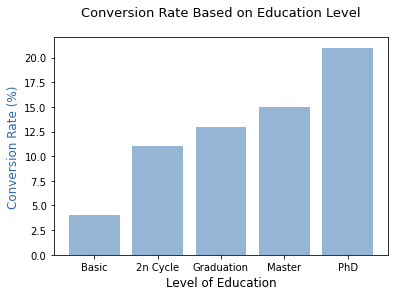

In [8]:
import matplotlib.pyplot as plt

def conversion_rate(variable, df):
    """Function to calculate the conversion rate"""
    conv_users = df.groupby(variable)['Response'].sum()
    total_users = df[variable].value_counts()
    conversion_rate = round((conv_users/total_users)*100,0)
    return conversion_rate

edu_conv_rate = conversion_rate('Education', 
                                df=marketing).sort_values()

plt.bar(edu_conv_rate.index, 
        edu_conv_rate, 
        color='#2f6aa8', 
        alpha=0.5)


plt.xlabel('Level of Education', size=12)
plt.ylabel('Conversion Rate (%)', size=12)
plt.title('Conversion Rate Based on Education Level\n', size=13);

One of the reason that could be the first suspect to cause these values of conversion rate is the number of customers in these categories. However, a closer look reveals that despite those with basic education consisting of only 54 participants, there conversion rate is still lower as compared to those with the graduation status, the majority (1127 participants). 

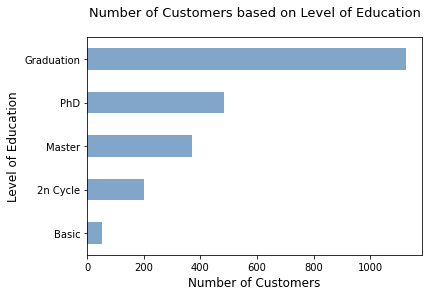

In [9]:
(marketing['Education'].value_counts(ascending=True)
                       .plot(kind='barh', 
                             color='#2f6aa8', 
                             alpha=0.6))

plt.ylabel('Level of Education', size=12)
plt.xlabel('Number of Customers', size=12)
plt.title('Number of Customers based on Level of Education\n', 
          size=13);

This prompts at looking at the average household income based on these education groups. Before plotting a graph to show this distribution, a function is defined for the plot.

In [10]:
def twin_plot(df, col1, col2, xlabel):
    """
    Plots twin plots.
    col1 & col2 are the columns to be plotted
    xlabel is the label of x axis
    """
    
    fig, ax = plt.subplots(figsize=(7,6))
    
    ax2 = ax.twinx()

    ax.bar(df.index, df[col1], 
           color='#2f6aa8', 
           alpha=0.5, 
           label=col1)
    
    ax2.plot(df.index, 
             df[col2], '--D',
             color = '#be4e00', 
             alpha=0.8, 
             label=col2)

    ax.legend(loc='upper center')
    ax2.legend()
    
    ax.set_xlabel(xlabel, size=12)
    
    ax.set_ylabel(str(col1), 
                  color='#2f6aa8', 
                  size=12)

    ax2.set_ylabel(str(col2), 
                   color='#be4e00', 
                   size=12)

    ax.set_title('Conversion Rate Based on '+ str(col1),
                 size=13, y=1.02);

Upon examination, it is clear that customers with basic education have the lowest average household income of about 20000 dollars. This value is approximately half times lower than those who are enrolled for a second education cycle (about 47000 dollars).

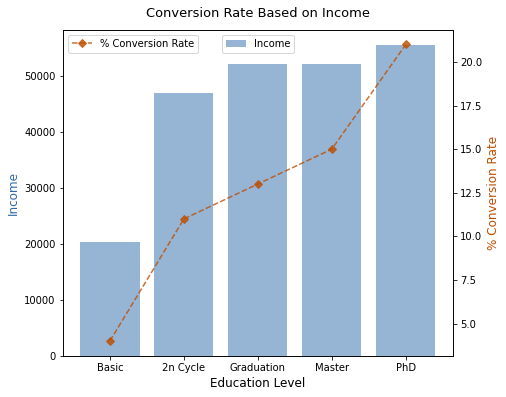

In [11]:
income_education = (marketing.groupby('Education')
                    ['Income'].mean())

education_income = (pd.concat([income_education, 
                               edu_conv_rate], 
                              axis=1)
                    .sort_values(0)
                    .rename(columns={0: '% Conversion Rate'}))

twin_plot(education_income, 
          'Income', 
          '% Conversion Rate', 
          'Education Level')

## Marital Status and Success Rates

Interesting to see that customers who are either married or together having the lowest conversion rate (11 and 10 respectively against the overall 15%). Customers with the absurd and YOLO status have an outstanding conversion rate (eacth at 50% against the overall 15%).

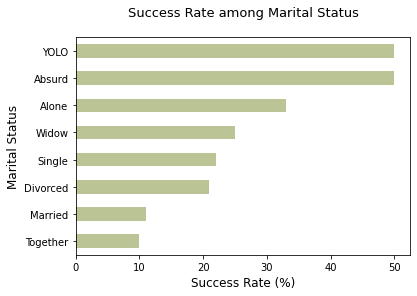

In [12]:
marital_conv_rate = conversion_rate('Marital_Status', marketing)

(marital_conv_rate
 .sort_values()
 .plot(kind='barh', 
       color='#8c9d4f', 
       alpha=0.6))

plt.ylabel('Marital Status', size=12)
plt.xlabel('Success Rate (%)', size=12)
plt.title('Success Rate among Marital Status\n', size=13);

Upon checking, the YOLO and absurd marital status each have two participants which translates to one participant in each class successfully accepting the offer and the other one declining that's why the 50% conversion rate. The same applies to customers who identify as lone who are only three. This result can, therefore, be misleading! It is also evident that those who are married or together constitute the majority of the customers (864 and 579 customers respectively) meaning that the marketing department should look for ways to increase the conservation rate among these groups.

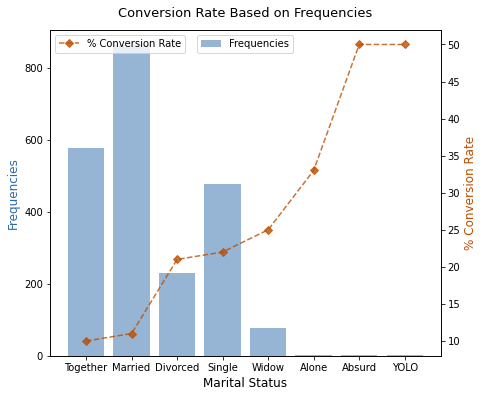

In [13]:
marital_count = marketing['Marital_Status'].value_counts()

marital_conv_frq = (pd.concat([marital_count, marital_conv_rate], 
                              axis=1)
                    .rename(columns={'Marital_Status': 'Frequencies', 
                                     0: '% Conversion Rate'})
                    .sort_values('% Conversion Rate'))

twin_plot(marital_conv_frq, 
          'Frequencies', 
          '% Conversion Rate', 
          'Marital Status')

Regarding the customers in the married or together group, the reason for their low success rate could be because of the number of dependants. These two groups have the highest number of dependants. This may imply that their resources are channeled to other needs.

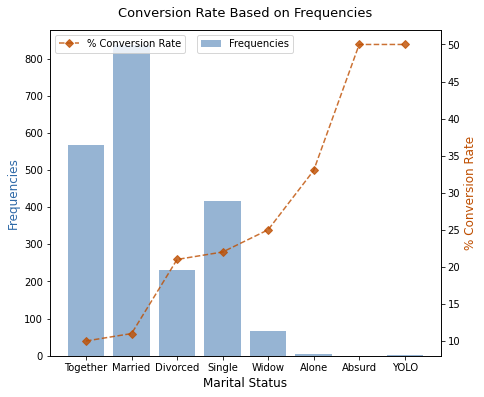

In [14]:
dependant_count = (marketing
                   .groupby('Marital_Status')
                   ['Dependants']
                   .sum())

dep_conv = (pd.concat([marital_count, dependant_count, 
                       marital_conv_rate], axis=1)
            .rename(columns={0: '% Conversion Rate',
                             'Dependants': 'Frequencies'})
            .sort_values('% Conversion Rate'))

twin_plot(dep_conv, 
          'Frequencies', 
          '% Conversion Rate', 
          'Marital Status')

## Purchases based on Marital Status

Wine products leads in sales across the marital status group followed by meat products. The other products vary in sales across this groups. It is also evident that customers in the married, together, single, divorced, and widow groups are the top spenders while those in the absurd, alone and YOLO groups being the low spenders.

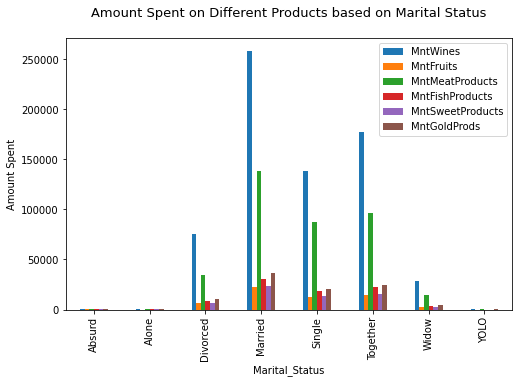

In [15]:
fig, ax = plt.subplots(figsize=(8,5))

(marketing
 .groupby('Marital_Status')[purch_cols]
 .sum()
 .plot(kind='bar', ax=ax))

plt.ylabel('Amount Spent')
plt.title('Amount Spent on Different Products based on Marital Status\n', 
          size=13);

## Age Group and Success Rate

The ages are classified into five categories: `25-34`, `35-44`, `45-54`, `55-64`, and `65+` And from the results it is clear that majority of the clients are aged between 45 to 54 while the least represented age group is between 25 and 34.

In [16]:
bins= [25,35,45,55,65, np.inf]
labels = ['25-34','35-44','45-54','55-64','65+']

marketing['Age_group'] = pd.cut(marketing['Age'], 
                                bins=bins, 
                                labels=labels, 
                                right=False)

marketing['Age_group'].value_counts()

45-54    732
55-64    488
65+      463
35-44    434
25-34    120
Name: Age_group, dtype: int64

Regarding success rate, segmenting the customers by age shows that there is no huge difference with the lowest success rate (12 per cent against the overall 15%) recorded for customers aged 55-64 while the highest (17 per cent against the overall 15%).

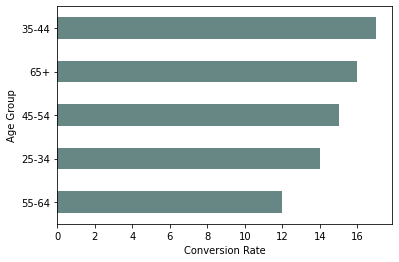

In [17]:
(conversion_rate('Age_group', marketing)
 .sort_values()
 .plot(kind='barh', color='#678785'))
plt.ylabel('Age Group')
plt.xlabel('Conversion Rate');

## Subscription Duration and Success Rate

Despite being the minority, customers with ten years subscriptions have the highest conversion rate (27% against  the overall 15%) while those with eight years have the lowest conversion rate (9%)

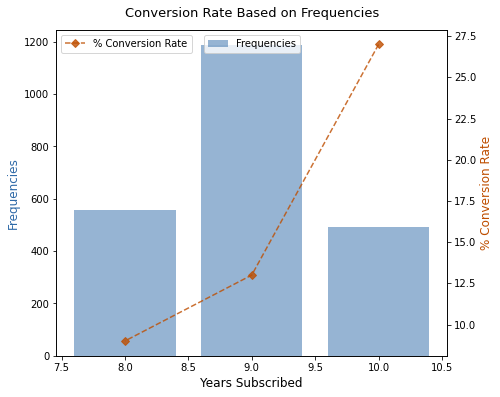

In [18]:
year_conv = conversion_rate('Years_Subscribed', marketing)
year_count = marketing['Years_Subscribed'].value_counts()

dur_sub = (pd.concat([year_conv, year_count], axis=1)
           .rename(columns={0: '% Conversion Rate', 
                            'Years_Subscribed': 'Frequencies'})
           .sort_values('% Conversion Rate', ascending=False))

twin_plot(dur_sub, 
          'Frequencies', 
          '% Conversion Rate', 
          'Years Subscribed')

# **CLUSTERING FOR SEGMENTATION**

To avoid overlooking of customers' behavioral patterns, clustering will be used instead of personal intuitions during segmentation. For this case study, the criteria for segmentation is that regardless of marital status, and education level, the customers are separated based on their income level,  age, and purchase totals. Using these criteria, the results can be differential marketing strategy for customers that have, say, high income and low purchasing versus those with low income and high purchasing.

In [19]:
cols = ['Income', 'Age', 'Purchase_total', 'Response']
marketing_clust = marketing[cols]

## Training and Validation Data

First the data is separated into training and testing portions to test for the accuracy of the clustering method used.

In [20]:
from sklearn.model_selection import train_test_split

X_data = marketing_clust.drop('Response', axis=1)
y_data = marketing_clust['Response']

X_train, X_test, y_train, y_test =\
    train_test_split(X_data, y_data, 
                     test_size=0.3, 
                     random_state=123)

X_train.shape, X_test.shape

((1565, 3), (672, 3))

## Standardization 

Next we standardize the training data and upon verification the mean value of practically all the columns is 0 and the standard deviation is 1. This ensures that all the columns get equal weight when calculation the similarity or distance between customers.

In [21]:
from sklearn.preprocessing import StandardScaler
from warnings import filterwarnings
filterwarnings('ignore')

scaler = StandardScaler()

clust_cols = ['Income', 'Age', 'Purchase_total']
scaled_cols = ['Income_scaled', 'Age_scaled', 'Purchase_scaled']
X_train[scaled_cols] = scaler.fit_transform(X_train[clust_cols])

## Kmeans Clustering and Dimensionality Reduction

To choose an appropriate number clusters, the silhouttes score is used to measure how well a clustering fit the data. In this case, the higher score (optimal number of clusters) is from two clusters.

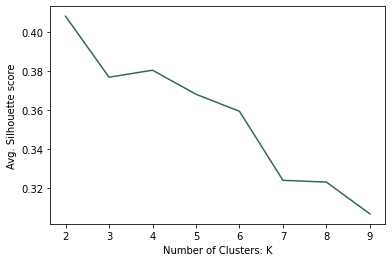

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = []

for k in range(2, 10):
    km_model = KMeans(n_clusters=k, random_state=123)
    cluster_assignments = km_model.fit_predict(X_train[scaled_cols])
    sil_scores.append(silhouette_score(X_train[scaled_cols], 
                                       cluster_assignments))

plt.plot(range(2, 10), sil_scores, color='#306958')
plt.ylabel('Avg. Silhouette score')
plt.xlabel('Number of Clusters: K');

## Evaluating KMeans Performance

A kmean model is created setting the number of clusters to 2 and fit to the training data in order to predict the clusters. The average silhouette score for this number of clusters is 0.51.

In [23]:
km_model = KMeans(n_clusters=2, random_state=123)
X_train['Income_Clusters'] = (km_model
                              .fit_predict(X_train[scaled_cols]))

silhouette_score(X_train[clust_cols], X_train['Income_Clusters'])

0.5148667283130242

For the test data, the average silhouette score (0.53) is an improvement from that computed for the training data (0.51).

In [24]:
X_test[scaled_cols] = scaler.fit_transform(X_test[clust_cols])
X_test['Income_Clusters'] = (km_model
                             .predict(X_test[scaled_cols]))

silhouette_score(X_test[clust_cols], X_test['Income_Clusters'])

0.5255843464077297

To understand the cause for this increase, a visualization will be created on the training and test data. But first, the data is reduced to two dimensions using PCA while preserving the distance between the points.

In [25]:
from sklearn.decomposition import PCA

def pca_output(data):
    return PCA(n_components=2).fit_transform(data[scaled_cols])

pca_train = pca_output(X_train)
pca_test = pca_output(X_test)

X_train['pc1'], X_train['pc2'] = pca_train[:,0], pca_train[:,1]
X_test['pc1'], X_test['pc2'] = pca_test[:,0], pca_test[:,1]

Before going ahead, a function is defined to plot clusters.

In [26]:
markers = ['.', 'x']
colors = ['#ed7d00', '#61b4f6']
alpha = [0.6, 0.6]

def plot_clusters(data):
    for clust in range(data['Income_Clusters'].nunique()):
        
        temp = data[data['Income_Clusters']==clust]
        
        plt.scatter(temp['pc1'], temp['pc2'], 
                    marker=markers[clust], 
                    label='cluster '+str(clust), 
                    color=colors[clust], 
                    alpha=alpha[clust])

    plt.legend(loc='upper left')
    plt.xlabel('PC1')
    plt.ylabel('PC2');

The x and y axes are Principal Components and therefore not easily interpretable being that they are derived from combinations of the original features. However, by visualizing the clusters, it is evident how good the clusters are based on how much they overlap. However, there is a data point that is far from its cluster.

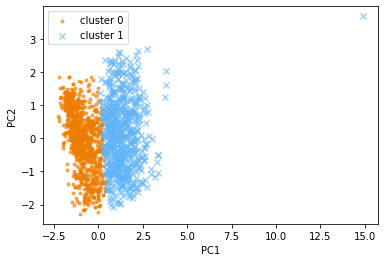

In [27]:
import seaborn as sns

plot_clusters(X_train)

The outlier is also evident in the average household income.

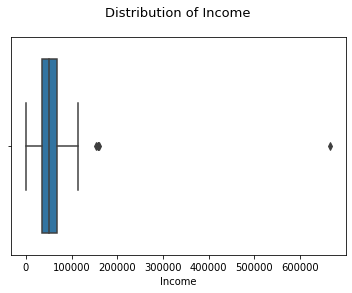

In [28]:
sns.boxplot(X_train['Income'])
plt.title('Distribution of Income\n', size=13);

In the test data, the improvement of the average silhouette can be attributed to the tight clusters.

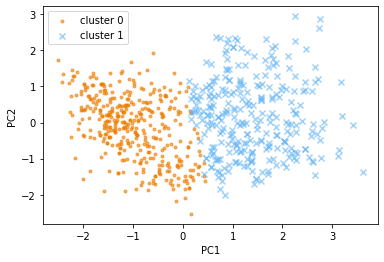

In [29]:
plot_clusters(X_test)

To understand the clusters, the average values of the original features used for clustering can be computed against the two clusters visually. From the results it is clear that the income and purchase totals varies significantly between the clusters and perhaps for age.

In [30]:
X_test.groupby('Income_Clusters')[clust_cols].mean()

,Income,Age,Purchase_total
Income_Clusters,,,
0,37079.817481,51.431877,179.776350
1,72164.367491,56.081272,1225.250883


## Interpreting Clusters

As an interpretation, cluster 0 can be said to be comprised of high income customers with high purchasing habits while cluster 1 consist of customers who have low income earner and thus lower spenders. The age difference is not that large but it is evident that those in cluster 0 are somewhat older than those in cluster 1. Note that for this visualization, the standardized values are used instead of the original feature values due to scaling.

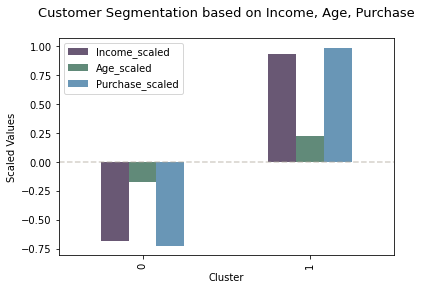

In [31]:
(X_test
 .groupby('Income_Clusters')[scaled_cols]
 .mean()
 .plot
 .bar(color=['#442e51', '#396d58', '#447ca4'], 
      alpha=0.8))

plt.axhline(0, 
            color='#aba396', 
            linestyle='--', 
            alpha=0.5)
plt.ylabel('Scaled Values')
plt.xlabel('Cluster')
plt.title('Customer Segmentation based on Income, Age, Purchase\n', 
          size=13);

With this information, it is evident that customers classified as low income earners and spenders have low conversion rate (10 percent against the overall 15 percent) while those categorized as high income earners and spenders have a high conversion rate (23 percent against the overall 15 percent).

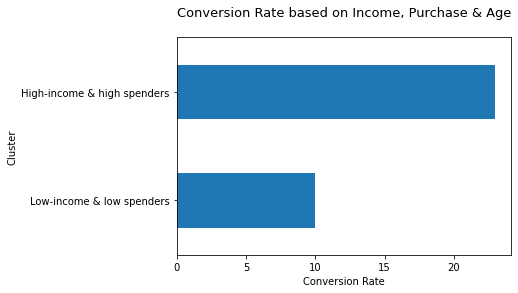

In [32]:
income_cluster = pd.concat([X_test['Income_Clusters'], 
                            y_test], 
                           axis=1)

(conversion_rate('Income_Clusters', income_cluster)
 .plot.barh())

plt.yticks(ticks=[0, 1], 
           labels=['Low-income & low spenders', 
                   'High-income & high spenders'])
plt.xlabel('Conversion Rate')
plt.ylabel('Cluster')
plt.title('Conversion Rate based on Income, Purchase & Age\n', 
          size=13);

# **CREATING A PREDICTIVE MODEL**

The aim of this section is to create a predictive model which will allow the company to maximize the profit of the next marketing campaign.

## Selecting Necessary Variables

First, the selection of variables to proceed with is important.

1. All the variables that were created for the purpose of customer segmentation analysis will be dropped.
 
2. Variables like `Z_CostContact` and `Z_revenue` have constant values across each entry thus they are also removed. 

In [33]:
col_remove = ['ID', 'Z_CostContact', 'Z_Revenue', 'Age_group', 
              'Number_Purchases', 'Purchase_total', 'Dependants']
marketing = marketing.drop(col_remove, axis=1)

## One Hot Encoding 

The categorical columns are also converted to numerical data types to allow for the use of the algorithms that will be used when creating a predictive model.

In [34]:
categ_cols = ['Education', 'Marital_Status']
marketing = pd.get_dummies(marketing)

Next, the data is split into training and validation sets

In [35]:
X_data = marketing.drop('Response', axis=1)
y_data = marketing['Response']

X_train, X_val, y_train, y_val =\
    train_test_split(X_data, y_data, random_state=123, test_size=0.30)

Before proceeding, a function is created that contains a pipeline to scale the data and fit a classifier. The function then outputs the accuracy scores.

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, 
                             confusion_matrix,
                             classification_report)
    
def pipe_fit_score(classifier):
    venue_pipe = Pipeline([('scaler', StandardScaler()), 
                           ('clf', classifier)])
    
    y_pred = venue_pipe.fit(X_train, y_train).predict(X_val)
    
    print(pd.DataFrame(confusion_matrix(y_val, y_pred), 
                        columns=['Positive', 'Negative'], 
                        index=['Positive', 'Negative']))
    print()
    print(classification_report(y_val, y_pred))
    print()
    return roc_auc_score(y_val, y_pred)

### Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
pipe_fit_score(LogisticRegression())

          Positive  Negative
Positive       555        12
Negative        55        50

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       567
           1       0.81      0.48      0.60       105

    accuracy                           0.90       672
   macro avg       0.86      0.73      0.77       672
weighted avg       0.89      0.90      0.89       672




0.7275132275132276

### Random Forest Classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=123)
pipe_fit_score(rfc)

          Positive  Negative
Positive       557        10
Negative        70        35

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       567
           1       0.78      0.33      0.47       105

    accuracy                           0.88       672
   macro avg       0.83      0.66      0.70       672
weighted avg       0.87      0.88      0.86       672




0.6578483245149912

### K-Neighbor Classifier

In [39]:
from sklearn.neighbors import KNeighborsClassifier
pipe_fit_score(KNeighborsClassifier())

          Positive  Negative
Positive       561         6
Negative        80        25

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       567
           1       0.81      0.24      0.37       105

    accuracy                           0.87       672
   macro avg       0.84      0.61      0.65       672
weighted avg       0.86      0.87      0.84       672




0.6137566137566137

### Support Vector Machine

In [40]:
from sklearn.svm import SVC
pipe_fit_score(SVC())

          Positive  Negative
Positive       564         3
Negative        84        21

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       567
           1       0.88      0.20      0.33       105

    accuracy                           0.87       672
   macro avg       0.87      0.60      0.63       672
weighted avg       0.87      0.87      0.83       672




0.5973544973544973

## Classification

When default parameters are used, logistic regression gives the best predictive scores in terms of accuracy (90 percent) and also the area under curve (0.72). More on classification will be tackled later on.

## Hyperparameter Tuning

In this section, the model parameters are tuned to determine the best model parameters that can be used for prediction

In [41]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_rfc = { 
    'n_estimators': [50, 100, 200],
    'max_features': ['auto'],
    'max_depth' : [None,3,5,8],
    'criterion' :['gini'],
    'min_samples_split':[2,3,4]}

rfc_cv = GridSearchCV(RandomForestClassifier(random_state=5),
                            param_grid=param_rfc,
                            cv=5, verbose=1)

rfc_cv.fit(X_train, y_train)
rfc_tune_acc = pipe_fit_score(rfc_cv.best_estimator_)
print('Accuracy: ', rfc_tune_acc)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
          Positive  Negative
Positive       560         7
Negative        69        36

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       567
           1       0.84      0.34      0.49       105

    accuracy                           0.89       672
   macro avg       0.86      0.67      0.71       672
weighted avg       0.88      0.89      0.87       672


Accuracy:  0.6652557319223986
